# COGS 108 - Final Project

### Group Members
- Aaron Lee
- Cassie Zhu (A13738990)
- Tina Chen
- Dillon Handal
- Emery Lin

### Overview
+ 3.5 pts for intro & background section
+ TODO: clear summary of what we did (3-4 sentences max)

### Intro
Anime is the Japanese word for animation. Outside of Japan, the term refers to a popular style of Japanese animation characterized by vibrant graphics and colorful characters. It has an appeal that bypasses borders and nationalities, captivating people of all ages across the globe.

### Research Question
How does an anime fan's age influence their level of engagement with the general anime community?

Our dataset supplies all the necessary information that we will need to answer this question.

### Background & Prior Work
This project is looking at examining if there is a trend with user age vs engagement. We define engagement as the total number of anime watched. Since the dataset we are looking at has been used mostly for machine learning and recommender systems, our research question is completely different and therefore, there is not much work that has been done previously on it. We had looked at the following two sources:
- https://myanimelist.net/
- https://www.kaggle.com/CooperUnion/anime-recommendations-database

MyAnimeList (MAL) contains the entirety of the anime database and the secondary kaggle link was a smaller fraction of it. However, the kaggle dataset here was more difficult to use because it was a smaller dataset compared to the one we found.

### Hypothesis
Hypothesis: As anime fans age, they watch less anime and engage less with the community. 

Explanation: We believe our hypothesis is correct because older people have more obligations to their job, family, etc. Thus, older anime fans will have less free time to indulge in their hobby.

# Dataset

Name: MyAnimeList Dataset

Link to the dataset: https://www.kaggle.com/azathoth42/myanimelist

Number of observations: anime_filtered.csv, animelists_filtered.csv and users_filtered.csv collectively contain
+ 116,133 unique users with demographic data
+ 35,802,010 records in anime lists
+ 14,474 unique anime

The cleaned versions (anime_cleaned.csv, animelists_cleaned.csv, users_cleaned.csv) removed a negligible amount of observations.

Description: A cleaned kaggle dataset populated by information from MyAnimeList, one of the largest consolidations of anime titles and user ratings/info in the fandom.

# Data Analysis

### Setup

In [13]:
%matplotlib inline

# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
from bs4 import BeautifulSoup
from time import sleep
from IPython.display import clear_output

import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest

from collections import defaultdict

In [2]:
# Configure libraries
# The seaborn library makes plots look nicer
sns.set()
sns.set_context('talk')

# Don't display too many rows/cols of DataFrames
pd.options.display.max_rows = 10
pd.options.display.max_columns = 10

# Round decimals when displaying DataFrames
pd.set_option('precision', 2)

In [3]:
# import csv
usersCleaned = pd.read_csv('users_cleaned.csv')

In [4]:
usersCleaned.head()

,username,user_id,user_watching,user_completed,user_onhold,...,join_date,last_online,stats_mean_score,stats_rewatched,stats_episodes
0,karthiga,2255153,3,49,1,...,2013-03-03 00:00:00,2014-02-04 01:32:00,7.43,0.0,3391
1,Damonashu,37326,45,195,27,...,2008-02-13 00:00:00,2017-07-10 06:52:54,6.15,6.0,4903
2,bskai,228342,25,414,2,...,2009-08-31 00:00:00,2014-05-12 16:35:00,8.27,1.0,9701
3,terune_uzumaki,327311,5,5,0,...,2010-05-10 00:00:00,2012-10-18 19:06:00,9.70,6.0,697
4,Bas_G,5015094,35,114,6,...,2015-11-26 00:00:00,2018-05-10 20:53:37,7.86,0.0,1847


### Data Cleaning
+ 3.5pts
+ TODO: perform data cleaning or explain steps taken OR include explanation why data cleaning is unecessary (how did you determine the dataset was ready to go). Dataset should actually be clean and usable after the data cleaning steps are carried out

The kaggle set is pre-cleaned. We just need to check that the distribution of data is normal or at least if there is any bias, we are able to spot it out immediately. Some data may not be accurate so we would also need to prune and check for those.

In [ ]:
# add age column to usersFiltered data frame
# convert birth_date to age because birth_date is private data.
now = pd.Timestamp('now')
usersCleaned['birth_date'] = pd.to_datetime(usersCleaned['birth_date'], format='%Y-%m-%d')
usersCleaned['age'] = (now - usersCleaned['birth_date']).astype('<m8[Y]').astype(int)

### Data Visualization
+ 5.25pts
+ TODO: include at least 3 visualizations. All axes on plots should be clearly labeled. Types of all plots are appropriate given data displayed. Interpretation of each visualization included in text

Since we're interested in the age distribution, we can plot the age groups and total anime watched per age group to get an idea if we have a balanced dataset.

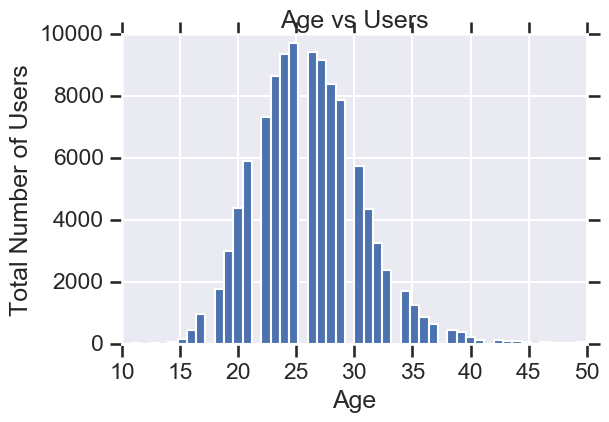

In [11]:
# plot histogram of age range
histogram = usersCleaned.hist(column="age", bins=50)
plt.title('Age vs Users')
plt.xlabel('Age')
plt.ylabel('Total Number of Users')
plt.show()

This has a normal distibution, centered around age 25. Given that our age range is mostly constricted around the twenties to forties, we can break our age group further into generational gaps to find a certain pattern that helps answer our research question.

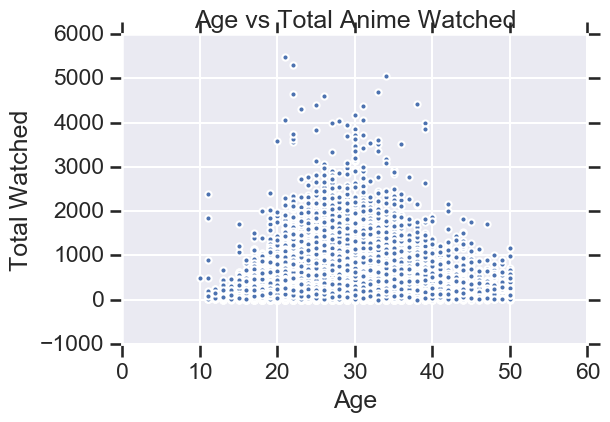

In [7]:
# plot age groups to total anime watching or completed
usersCleaned['total_watched'] = usersCleaned['user_watching'] + usersCleaned['user_completed']

plot = usersCleaned[['age', 'total_watched']].plot.scatter('age', 'total_watched')
plt.title('Age vs Total Anime Watched')
plt.xlabel('Age')
plt.ylabel('Total Watched')
plt.show()

We can see a normal distribution of age to total watched, with a larger concentration around the mid 20s to mid 30s.

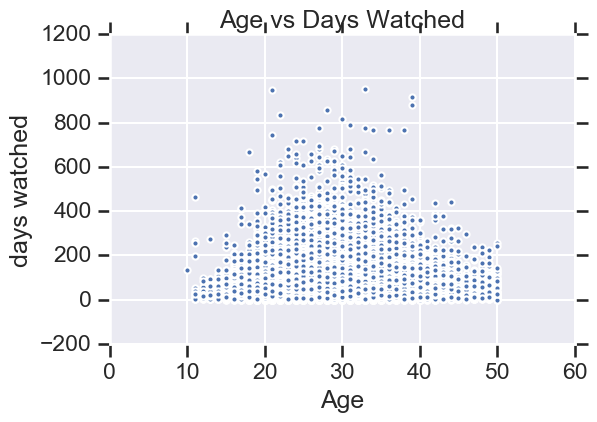

In [8]:
#scatter plot for age vs days watched
df = pd.DataFrame(usersCleaned)
df['age'] = pd.to_numeric(df['age'])
df['user_days_spent_watching'] = pd.to_numeric(df['user_days_spent_watching'])
#scatter plot 
ax = df.plot( x = 'age',y = 'user_days_spent_watching',kind = 'scatter')
plt.ylabel('days watched')
plt.xlabel('Age')
plt.title('Age vs Days Watched')

plt.show()

This has a similar distribution to Age vs Total Watched, where the amount of time spent watching anime is concenctrated around the 20s to mid 30s.

### Data Analysis & Results
+ 8.75pts
+ TODO: EDA carried out w/ explanations of what was done & intepretations of output included. Appropriate analysis performed. Output of analysis interpreted & interpretation included in notebook

Our earlier visualizations showed that all our users fall between the age range of 10-50, so we can limit or analysis to these ages.

To better understand how these visualizations show __age vs time spent watching__, we break it down into smaller age ranges of 5. First, we take a look at the average days spent watching for each age range:

In [43]:
#gets the data of average and total days watched for age groups\
age_sum = defaultdict(int)
age_count = defaultdict(int)

for i, r in df.iterrows():
    if r['age'] <= 50:
        age_range = str(((r['age']) // 5) * 5)
        age_sum[age_range] += r['user_days_spent_watching']
        age_count[age_range] += 1

defaultdict(<type 'int'>, {'25': 44535, '45': 235, '15': 6380, '10': 110, '30': 17445, '50': 54, '35': 3647, '40': 697, '20': 35608})


       Age  Average % of Year Spent Watching  Average Days Watched
0  10 - 14                              0.13                 46.16
1  15 - 19                              0.14                 48.46
2  20 - 24                              0.16                 57.47
3  25 - 29                              0.18                 63.12
4  30 - 34                              0.20                 70.05
5  35 - 39                              0.21                 74.44
6  40 - 44                              0.20                 70.28
7  45 - 49                              0.16                 57.70
8  50 - 54                              0.15                 53.50


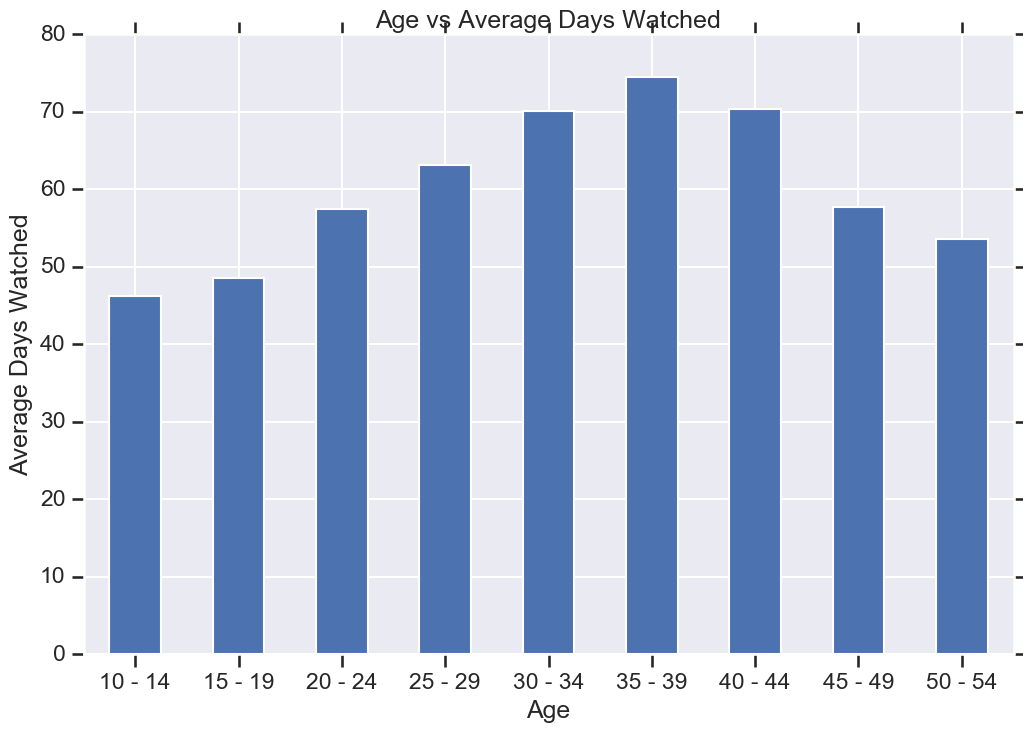

In [36]:
#average days watched per age group
avg_days = []
avg_percent_of_year = []
ranges = sorted(age_sum.items())
for age, sum in ranges:
    avg_days.append(sum/age_count[age])
    avg_percent_of_year.append(sum/age_count[age]/356)
    
dataAverage = {'Age':['10 - 14','15 - 19','20 - 24','25 - 29','30 - 34','35 - 39','40 - 44','45 - 49','50 - 54'], 
        'Average Days Watched': avg_days,
        'Average % of Year Spent Watching': avg_percent_of_year} 
#plot data
dfGroupedAverage = pd.DataFrame(dataAverage)
ax1 = dfGroupedAverage.plot.bar(x='Age', y='Average Days Watched', rot=0,figsize = (12,8),title = 'Age vs Average Days Watched',legend = False)
ax1.set_ylabel('Average Days Watched')
print(dfGroupedAverage)

Breaking this down further, we can see that the age group 35 - 39 has the highest average of days spent watching anime at about 74 days. The rest of the ages show a nice bell curve around that peak. This analysis does support our hypothesis that that anime fans watch less as they age, but the difference in average days watched actually doesn't differ that much between the age ranges, the lowest being 13% of the year spent watching anime and the highest being 21%, making it a 8% difference.

However, our earlier "Age vs Users" visualization shows a large dropoff in users after 30, with there barely being any users ~50. The average days watched of users of 40 doesn't drop off quite as much though and actually remains higher than the average days of users below 20 when people are starting to watch anime, which means that even though the amount of people who continue to watch anime past their 30s decreases steeply, as we hypothesized, those who continue to watch are still dedicated and invest a similar amount of time into their hobby.

This is better reflected when we look at the total number of days each age range has watched:

       Age  Total Days Watched In Thousands
0  10 - 14                             5.08
1  15 - 19                           309.18
2  20 - 24                          2046.38
3  25 - 29                          2811.08
4  30 - 34                          1222.08
5  35 - 39                           271.49
6  40 - 44                            48.99
7  45 - 49                            13.56
8  50 - 54                             2.89


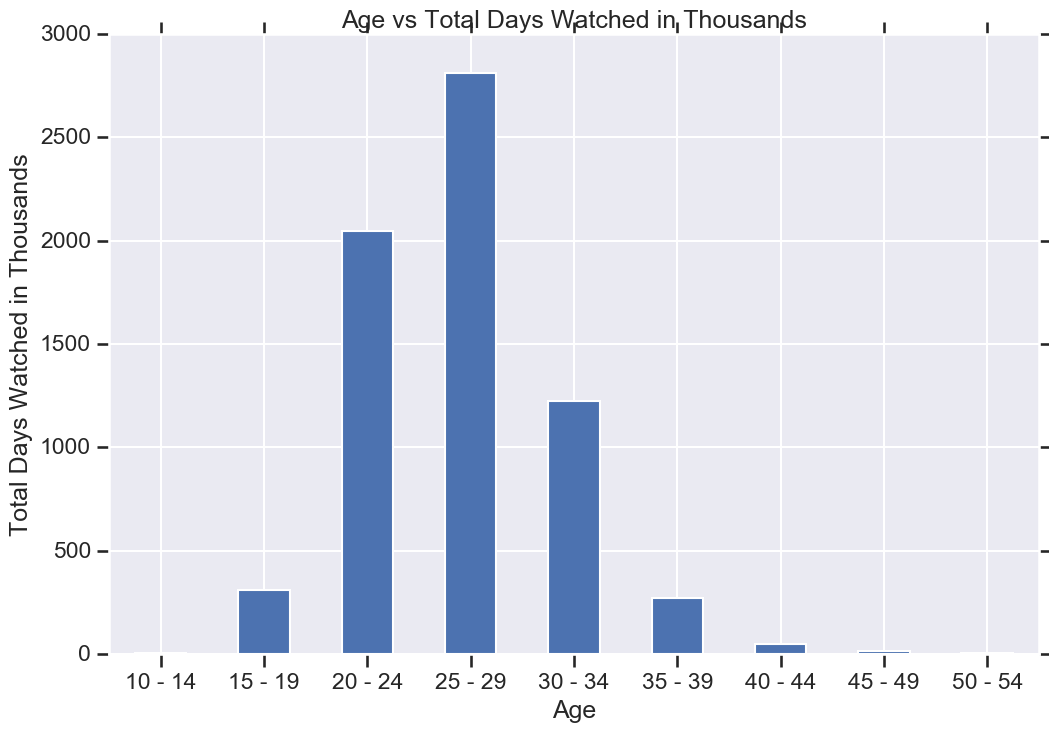

In [39]:
#total days watched per age group 
ranges = sorted(age_sum.items())
data = {'Age':['10 - 14','15 - 19','20 - 24','25 - 29','30 - 34','35 - 39','40 - 44','45 - 49','50 - 54'], 
        'Total Days Watched In Thousands': [sum for age, sum in ranges]}

dfGrouped = pd.DataFrame(data)
dfGrouped['Total Days Watched In Thousands'] = dfGrouped['Total Days Watched In Thousands'].div(1000)
ax2 = dfGrouped.plot.bar(x='Age', y='Total Days Watched In Thousands', rot=0,figsize = (12,8), title = 'Age vs Total Days Watched in Thousands',legend = False)
ax2.set_ylabel('Total Days Watched in Thousands')
print(dfGrouped)

As expected, this bar graph more closely resembles that of the "Age vs User" visualization earlier.

We use linear regression to take a closer at days vs user numbers, which shows that age does indeed significantly predict days spent watching, as shown by the p-value of 0.

In [74]:
#Linear Regression Shows that age does significantly predict days spent watching. This is shown by p-value of 0.
outcome_1, predictors_1 = patsy.dmatrices('user_days_spent_watching ~ age',df)
mod_1 = sm.OLS(outcome_1, predictors_1)
res_1 = mod_1.fit()
print(res_1.summary())

                               OLS Regression Results                               
Dep. Variable:     user_days_spent_watching   R-squared:                       0.009
Model:                                  OLS   Adj. R-squared:                  0.009
Method:                       Least Squares   F-statistic:                     1003.
Date:                      Sat, 30 Nov 2019   Prob (F-statistic):          4.97e-219
Time:                              17:31:23   Log-Likelihood:            -5.9742e+05
No. Observations:                    108711   AIC:                         1.195e+06
Df Residuals:                        108709   BIC:                         1.195e+06
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

To summarize our findings on age vs time, we've found that...

In [91]:
#seperates the data frame into older and younger groups <=30 and >30 
watched_young_data = df[df['age'] <= 30 ]['user_days_spent_watching'].values
watched_old_data = df[df['age'] > 30 ]['user_days_spent_watching'].values

In [94]:
#average of the two different groups 
avg_young = np.mean(watched_young_data)
avg_old = np.mean(watched_old_data)
total_young = np.sum(watched_young_data)
total_old = np.sum(watched_old_data)
print('Average days watched of people younger than 30 is \t {:2.2f} days'.format(avg_young))
print('Average days watched of people older than 30 is \t {:2.2f} days'.format(avg_old))
print('Total days watched of people younger than 30 is \t {:2.2f} days'.format(total_young))
print('Total days watched of people older than 30 is \t\t {:2.2f} days'.format(total_old))

Average days watched of people younger than 30 is 	 60.26 days
Average days watched of people older than 30 is 	 71.35 days
Total days watched of people younger than 30 is 	 5573999.32 days
Total days watched of people older than 30 is 		 1156719.74 days


In [127]:
#finds the weighted average of those older than 30 and those younger than 30.
w_avg_young = (avg_young * watched_young_data.size) / (watched_young_data.size + watched_old_data.size)
w_avg_old = (avg_old * watched_old_data.size) / (watched_old_data.size + watched_young_data.size)
print('Weighted average days watched of people younger than 30 is \t {:2.2f} days'.format(w_avg_young))
print('Weighted average days watched of people older than 30 is \t {:2.2f} days'.format(w_avg_old))

Weighted average days watched of people younger than 30 is 	 51.27 days
Weighted average days watched of people older than 30 is 	 10.64 days


Another thing we'd like to look at is __age vs how many anime currently watched__, to see if our hypothesis of user engagement decreasing also holds.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


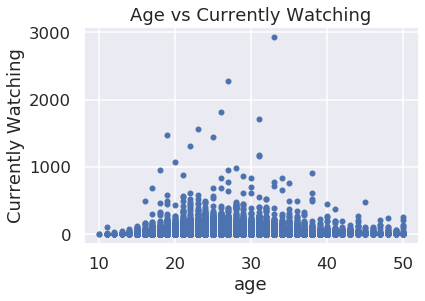

In [129]:
#graphs of age vs currently Watching
ax3 = df.plot( x = 'age',y = 'user_watching',kind = 'scatter')
plt.ylabel('Currently Watching')
plt.xlabel('Age')
plt.title('Age vs Currently Watching')

plt.show()

From this visualization we see several very obvious outliers, such as the user around age 34 who's currently watching almost 3000 shows, but generally the highest number of currently watching falls under the age range of 20s to mid 30s.

If we take a look at the averages of each user in the age ranges...

In [46]:
#gets the data of average and total currently watching for age groups
age_sum = defaultdict(int)
age_count = defaultdict(int)

for i, r in df.iterrows():
    if r['age'] <= 50:
        age_range = str(((r['age']) // 5) * 5)
        age_sum[age_range] += r['user_watching']
        age_count[age_range] += 1

       Age  Average Watching
0  10 - 14             10.16
1  15 - 19             14.13
2  20 - 24             14.54
3  25 - 29             14.58
4  30 - 34             15.23
5  35 - 39             16.84
6  40 - 44             19.06
7  45 - 49             21.90
8  50 - 54             22.96


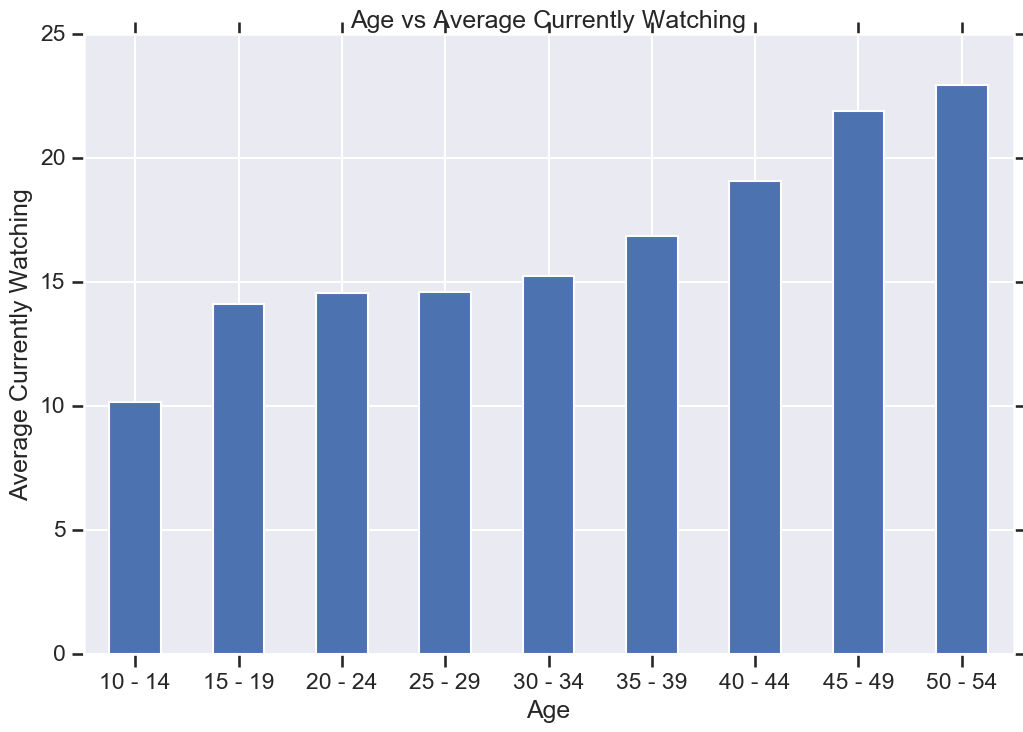

In [52]:
#average currently watching per age group
ranges = sorted(age_sum.items())
dataAverageWatching = {'Age':['10 - 14','15 - 19','20 - 24','25 - 29','30 - 34','35 - 39','40 - 44','45 - 49','50 - 54'], 
        'Average Watching': [float(sum)/age_count[age] for age, sum in ranges]}

dfAvg_watching = pd.DataFrame(dataAverageWatching)
ax1 = dfAvg_watching.plot.bar(x='Age', y='Average Watching', rot=0,figsize = (12,8),title = 'Age vs Average Currently Watching',legend = False)
ax1.set_ylabel('Average Currently Watching')
print(dfAvg_watching)


... we curiously see that the average currently watched actually increases with age, which seems to contradict our hypothesis that involvement with anime decreases as age increases. One possible explanation could be that because the user is older there is simply more anime available to watch (since more anime is created over time, so the number of existing anime always increases with age), so there is a larger selection to choose from. Another possible explanation is that users naturally forget to change the status of anime from "currently watching" to "finished" or "dropped" after adding it to their currently watching list. Thus, with a greater age, the user has more time to add more anime to their currently watching list (and forget to change its status) than younger users. In addition, they may also be more likely to forget to change the status due to increased responsibilities in their life occupying their mind more than their anime list, like we hypothesized.

To summarize our findings on age vs currently watching, we find that...

In [53]:
#total currently watching per age group 
dataWatching = {'Age':['10 - 14','15 - 19','20 - 24','25 - 29','30 - 34','35 - 39','40 - 44','45 - 49','50 - 54'], 
        'Total Watching': [sum for age, sum in ranges]} 
dfWatching = pd.DataFrame(dataWatching)
dfWatching['Total Watching'] = dfWatching['Total Watching'].div(1000)
# print(dfWatching)
# ax2 = dfWatching.plot.bar(x='Age', y='Total Watching', rot=0,figsize = (12,8), title = 'Age vs Total Currently Watching',legend = False)
# ax2.set_ylabel('Total Currently Watching in Thousands')

In [54]:
#seperates the data frame into older and younger groups <=30 and >30 
watching_young_data = df[df['age'] <= 30 ]['user_watching'].values
watching_old_data = df[df['age'] > 30 ]['user_watching'].values

In [55]:
#finds average for those older than 30 and those younger than 30 
avg_young = np.mean(watching_young_data)
avg_old = np.mean(watching_old_data)
total_young = np.sum(watching_young_data)
total_old = np.sum(watching_old_data)
print('Average days watched of people younger than 30 is \t {:2.2f} days'.format(avg_young))
print('Average days watched of people older than 30 is \t {:2.2f} days'.format(avg_old))
print('Total days watched of people younger than 30 is \t {:2.2f} days'.format(total_young))
print('Total days watched of people older than 30 is \t\t {:2.2f} days'.format(total_old))

Average days watched of people younger than 30 is 	 14.53 days
Average days watched of people older than 30 is 	 16.10 days
Total days watched of people younger than 30 is 	 1342386.00 days
Total days watched of people older than 30 is 		 263004.00 days


In [56]:
#finds the weighted average of those older than 30 and those younger than 30.
w_avg_young = (avg_young * watching_young_data.size) / (watching_young_data.size + watching_old_data.size)
w_avg_old = (avg_old * watching_old_data.size) / (watching_old_data.size + watching_young_data.size)
print('Weighted average days watched of people younger than 30 is \t {:2.2f} days'.format(w_avg_young))
print('Weighted average days watched of people older than 30 is \t {:2.2f} days'.format(w_avg_old))

Weighted average days watched of people younger than 30 is 	 12.35 days
Weighted average days watched of people older than 30 is 	 2.42 days


# Privacy / Ethics Considerations

Our dataset consists solely of public data, which is readily available with a quick google search. However, the data needs to be cleaned as it contains location data and usernames. We will need to parse to make sure there are no odd revealing pieces of data around. Once we have accomplished this part, the data we use and display would not reveal any confidential information. For example, the Safe Harbor method mentions that we should remove the birthdate from our dataset. We can do this and simply just replace it with age. Aside from this, we are in compliance with the Terms of Service provided by MyAnimeList so our data usage will be ethically safe. Furthermore, users on MyAnimeList are also able to restrict the view of their ratings list so if they did not want their ratings used by any third party application, they could simply restrict who is able to view their lists.

The data results from this project do not contain user sensitive information as everything is anonymized. The purpose of the project is just to see if there is a way to draw meaningful correlations between age and interaction. However, the results of the project may have some biased results as we will end up selecting a random population from the total users on MAL. This may create bias since it’s possible that users may have a preference to certain kinds of anime over others which would skew the data analysis and prediction. Furthermore, when this dataset scraped MAL, it's also possible that users listed the anime and their rating when they were younger. Thus, this dataset could possibly be skewed in the sense that there was more interaction when they were younger but just that they grew older and it shifted the results.

# Conclusion & Discussion
+ 5.25pts
+ TODO: clear conclusion (answers research question) and discussion of results. Limitations of analysis discussed. Does not ramble, only provide necessary info